# Comparison of Control samples across back-to-back batches

In this notebook, we'll retrieve batch control data for B039 and B040, two of our scRNA-seq pipeline batches.

We'll combine the data from these samples, perform normalization and dimensionality reduction, generate some UMAP plots, and perform some differential expression tests for some of the broad cell type labels generated by our labeling pipeline.

As we perform these analyses, we'll generate output files. At the end of the notebook, we assemble these output files and upload them back to HISE for later use in downstream applications.

In [1]:
import hisepy

import anndata
from datetime import date
import h5py
import os
import pandas as pd
import scanpy as sc
import scipy.sparse as scs

In [2]:
if not os.path.isdir('output'):
    os.mkdir('output')

sc.settings.figdir = 'output/'

out_files = []

## Helper functions

In [3]:
def cache_uuid_path(uuid):
    cache_base = '{home}/{cache}/'.format(
        home = hisepy.reader.CONFIG['IDE']['HOME_DIR'],
        cache = hisepy.reader.CONFIG['IDE']['CACHE_DIR']
    )
    cache_path = '{b}/{u}'.format(b = cache_base, u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [4]:
# define a function to read count data
def read_mat(h5_con):
    mat = scs.csc_matrix(
        (h5_con['matrix']['data'][:], # Count values
         h5_con['matrix']['indices'][:], # Row indices
         h5_con['matrix']['indptr'][:]), # Pointers for column positions
        shape = tuple(h5_con['matrix']['shape'][:]) # Matrix dimensions
    )
    return mat

# define a function to read obeservation metadata (i.e. cell metadata)
def read_obs(h5con):
    bc = h5con['matrix']['barcodes'][:]
    bc = [x.decode('UTF-8') for x in bc]

    # Initialized the DataFrame with cell barcodes
    obs_df = pd.DataFrame({ 'barcodes' : bc })

    # Get the list of available metadata columns
    obs_columns = h5con['matrix']['observations'].keys()
    
    # For each column
    for col in obs_columns:
        # Read the values
        values = h5con['matrix']['observations'][col][:]
        # Check for byte storage
        if(isinstance(values[0], (bytes, bytearray))):
            # Decode byte strings
            values = [x.decode('UTF-8') for x in values]
        # Add column to the DataFrame
        obs_df[col] = values

    obs_df = obs_df.set_index('barcodes', drop = False)
    obs_df = obs_df.drop(['umap_1', 'umap_2'], axis = 1)
    
    return obs_df

# define a function to construct anndata object from a h5 file
def read_h5_anndata(h5_file):
    h5_con = h5py.File(h5_file, mode = 'r')
    # extract the expression matrix
    mat = read_mat(h5_con)
    # extract gene names
    genes = h5_con['matrix']['features']['name'][:]
    genes = [x.decode('UTF-8') for x in genes]
    # extract metadata
    obs_df = read_obs(h5_con)
    # construct anndata
    adata = anndata.AnnData(mat.T,
                             obs = obs_df)
    # make sure the gene names aligned
    adata.var_names = genes

    adata.var_names_make_unique()
    return adata

## Find files in HISE data storage

In [5]:
help(hisepy.reader.get_file_descriptors)

Help on function get_file_descriptors in module hisepy.reader:

get_file_descriptors(query_dict: dict = None)
    Retrieves file descriptors based on user's query.
    
    Parameters:
        query_dict (dict): dictionary that contains query parameters
    Returns:
        dictionary of data.frame objects
    Examples:
        df_dict = get_file_descriptors(q_dict)
        df_dict.keys() # print keys of dict
        df_dict['descriptors'] # to view descriptors
        df_dict['labResults'] # lab results
        df_dict['specimens'] # specimen df



In [6]:
query_dict = {
    'fileType': ['scRNA-seq-labeled'],
    'cohortGuid': ['BIOIVT'],
    'batchID': ['B039','B040']
}

In [7]:
file_desc = hisepy.reader.get_file_descriptors(query_dict)

In [8]:
desc = file_desc['descriptors']

In [9]:
desc.shape

(4, 28)

In [10]:
desc['file.batchID'].value_counts()

file.batchID
B040    2
B039    2
Name: count, dtype: int64

In [11]:
desc['subject.subjectGuid'].value_counts()

subject.subjectGuid
HMN169517    4
Name: count, dtype: int64

## Retrieve labeled .h5 files from HISE

In [12]:
h5_uuids = desc['file.id'].tolist()

In [13]:
h5_files = []
for uuid in h5_uuids:
    h5_file = cache_uuid_path(uuid)
    h5_files.append(h5_file)

downloading fileID: 0b3c5cf8-6949-4410-953e-761bf3522b35
Files have been successfully downloaded!
downloading fileID: a7322df9-703d-45b6-a87a-bc86b176dbec
Files have been successfully downloaded!
downloading fileID: d2c39b0a-fe84-4fab-91fe-d273ad7a77c4
Files have been successfully downloaded!
downloading fileID: 865f1409-9a87-430f-b05d-3d167a5ca9d0
Files have been successfully downloaded!


In [14]:
h5_files

['/home/jupyter/cache//0b3c5cf8-6949-4410-953e-761bf3522b35/B040-P2_IMM19_413_2021-03-24T00:48:50.255094117Z_labeled.h5',
 '/home/jupyter/cache//a7322df9-703d-45b6-a87a-bc86b176dbec/B040-P1_IMM19_413_2021-02-14T05:03:10.129208213Z_labeled.h5',
 '/home/jupyter/cache//d2c39b0a-fe84-4fab-91fe-d273ad7a77c4/B039-P1_IMM19_412_2020-12-13T18:58:42.148340626Z_labeled.h5',
 '/home/jupyter/cache//865f1409-9a87-430f-b05d-3d167a5ca9d0/B039-P2_IMM19_412_2020-12-14T06:30:12.885244281Z_labeled.h5']

In [15]:
adata_list = []
for h5_file in h5_files:
    adata = read_h5_anndata(h5_file)
    adata_list.append(adata)

### Assemble all files

In [16]:
adata = sc.concat(adata_list)

## Normalize and generate UMAP for all cells

In [17]:
print('Normalizing', end = "; ")
# Normalize and log transform
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

print('Finding HVGs', end = "; ")
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

print('Scaling', end = "; ")
sc.pp.scale(adata)

print('PCA', end = "; ")
sc.tl.pca(adata, svd_solver = 'arpack')

print('Neighbors', end = "; ")
sc.pp.neighbors(
    adata, 
    n_neighbors = 50,
    n_pcs = 30
)

print('UMAP', end = "; ")
sc.tl.umap(adata, min_dist = 0.05)

Normalizing; Finding HVGs; 

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


Scaling; PCA; Neighbors; UMAP; 

### Extract and save UMAP coordinates and metadata

In [18]:
obs_umap = adata.obs
obs_umap = obs_umap.reset_index(drop = True)

umap_mat = adata.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])

obs_umap['umap_1'] = umap_df['umap_1']
obs_umap['umap_2'] = umap_df['umap_2']

In [19]:
obs_umap.to_csv('output/cell_meta_and_umap_coords.csv')
out_files.append('output/cell_meta_and_umap_coords.csv')

## Plot pools and cell type labels

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


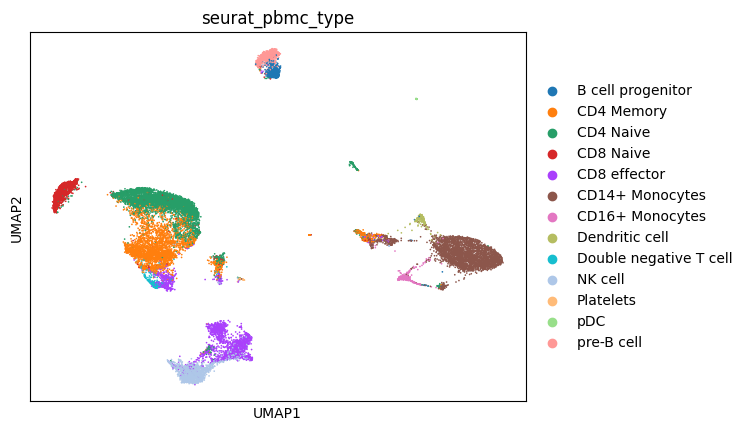

In [20]:
sc.pl.umap(
    adata,
    color = 'seurat_pbmc_type',
    save = '_cell_type.png'
)
out_files.append('output/umap_cell_type.png')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


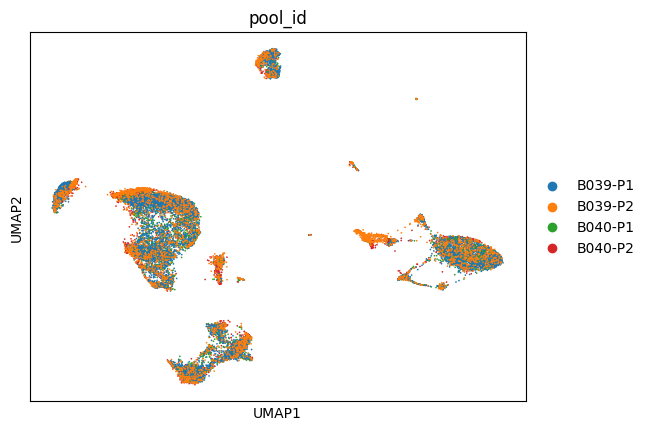

In [21]:
sc.pl.umap(
    adata,
    color = 'pool_id',
    save = '_all_pools.png'
)
out_files.append('output/umap_all_pools.png')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


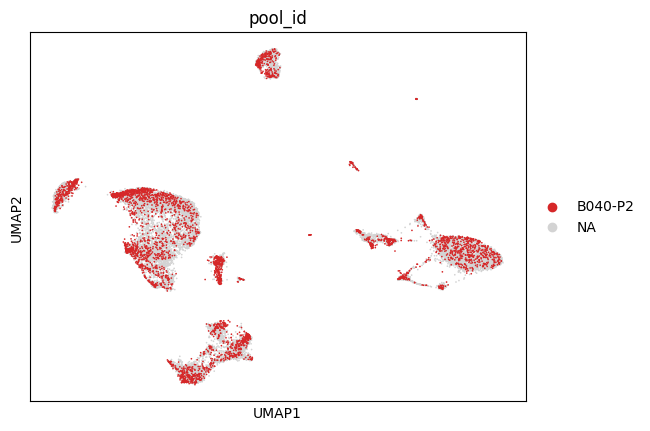

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


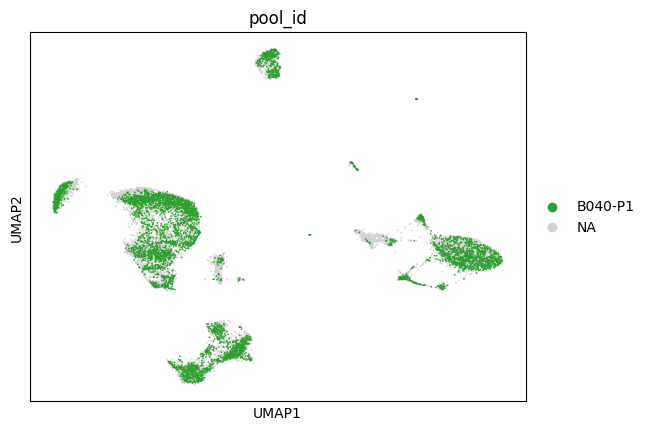

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


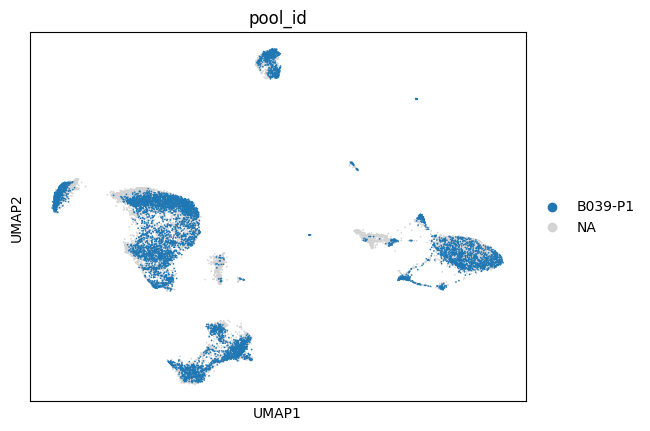

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


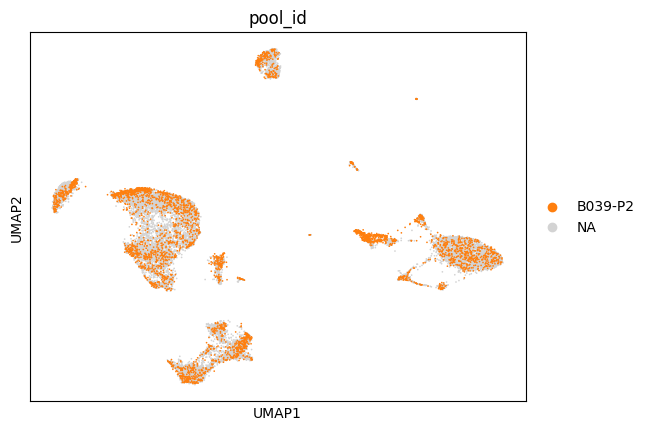

In [22]:
pools = adata.obs['pool_id'].unique()
for pool in pools:
    sc.pl.umap(
        adata,
        color = 'pool_id',
        groups = pool,
        save = '_{p}.png'.format(p = pool)
    )
    out_files.append('output/umap_{p}.png'.format(p = pool))

## Are there differences between batches in CD14 Monocytes?

In [23]:
cd14_adata = adata[adata.obs['seurat_pbmc_type'] == 'CD14+ Monocytes'].copy()

In [24]:
sc.tl.rank_genes_groups(
    cd14_adata,
    groupby = 'batch_id',
    method = 'wilcoxon',
    groups = ['B040'],
    reference = 'B039'
)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


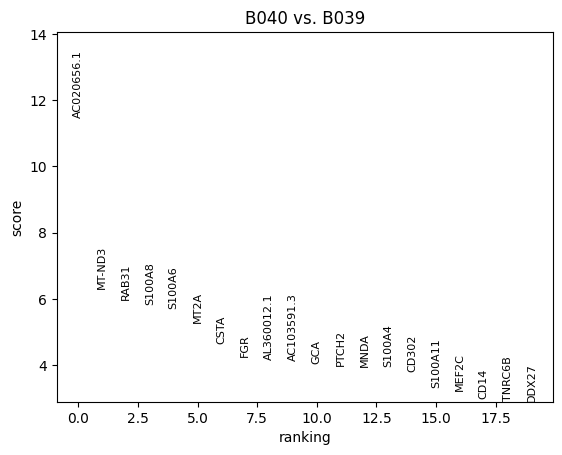

In [25]:
sc.pl.rank_genes_groups(cd14_adata)

In [26]:
def extract_result(adata, result):
    res_list = [x[0] for x in adata.uns['rank_genes_groups'][result].tolist()]
    return res_list

In [27]:
cd14_deg_df = pd.DataFrame({
    'gene': extract_result(cd14_adata, 'names'),
    'score': extract_result(cd14_adata, 'scores'),
    'pval': extract_result(cd14_adata, 'pvals'),
    'padj': extract_result(cd14_adata, 'pvals_adj'),
    'logfc': extract_result(cd14_adata, 'logfoldchanges')
})

In [28]:
cd14_deg_df.head()

,gene,score,pval,padj,logfc
0,AC020656.1,11.478743,1.687154e-30,2.577972e-27,0.542130
1,MT-ND3,6.300986,2.957584e-10,1.807676e-07,6.518433
2,RAB31,5.962602,2.482523e-09,1.264432e-06,0.443171
3,S100A8,5.825110,5.707489e-09,1.938010e-06,0.239199
4,S100A6,5.704852,1.164443e-08,3.558537e-06,0.178829


In [29]:
cd14_deg_df.to_csv('output/B040_vs_B039_cd14_mono_deg.csv')
out_files.append('output/B040_vs_B039_cd14_mono_deg.csv')

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


## How about in CD4 Naive T cells?

In [30]:
cd4_adata = adata[adata.obs['seurat_pbmc_type'] == 'CD4 Naive'].copy()

In [31]:
sc.tl.rank_genes_groups(
    cd4_adata,
    groupby = 'batch_id',
    method = 'wilcoxon'
)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


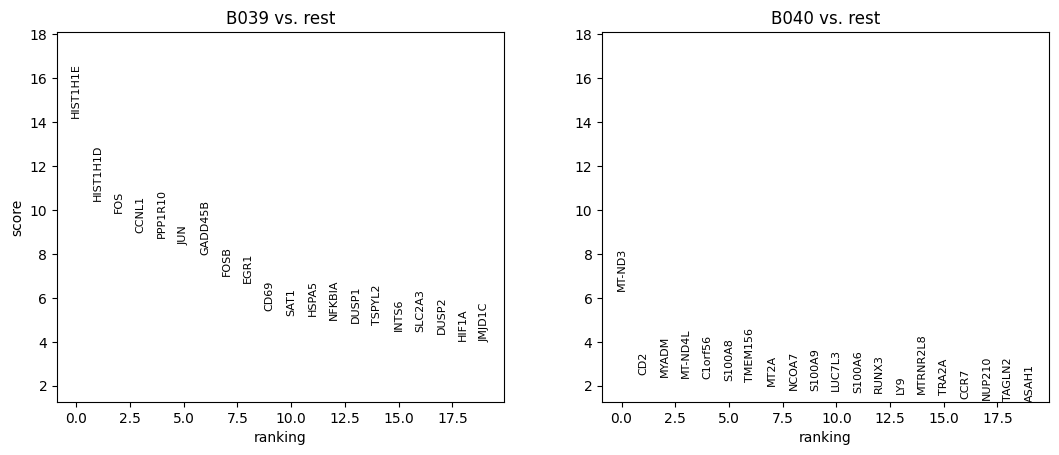

In [32]:
sc.pl.rank_genes_groups(cd4_adata)

In [33]:
cd4_deg_df = pd.DataFrame({
    'gene': extract_result(cd4_adata, 'names'),
    'score': extract_result(cd4_adata, 'scores'),
    'pval': extract_result(cd4_adata, 'pvals'),
    'padj': extract_result(cd4_adata, 'pvals_adj'),
    'logfc': extract_result(cd4_adata, 'logfoldchanges')
})

In [34]:
cd4_deg_df.head()

,gene,score,pval,padj,logfc
0,HIST1H1E,14.220998,6.787800e-46,2.074352e-42,-3.214036
1,HIST1H1D,10.440378,1.621636e-25,2.477860e-22,1.560905
2,FOS,9.864243,5.948174e-23,6.059207e-20,-0.549353
3,CCNL1,8.979241,2.726392e-19,2.082964e-16,-3.194128
4,PPP1R10,8.734870,2.439374e-18,1.490945e-15,NaN


In [35]:
cd4_deg_df.to_csv('output/B040_vs_B039_cd4_naive_deg.csv')
out_files.append('output/B040_vs_B039_cd4_naive_deg.csv')

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


Yes, there are a few differences. We should be mindful of these in our analysis.

## Save files for later use in HISE

In [36]:
study_space_uuid = '00a53fa5-18da-4333-84cb-3cc0b0761201'
title = 'CertPro Batch Control Comparison {d}'.format(d = date.today())

In [37]:
search_id = 'wellmannered_olingo'

In [38]:
in_files = desc['file.id'].tolist()
in_files

['0b3c5cf8-6949-4410-953e-761bf3522b35',
 'a7322df9-703d-45b6-a87a-bc86b176dbec',
 'd2c39b0a-fe84-4fab-91fe-d273ad7a77c4',
 '865f1409-9a87-430f-b05d-3d167a5ca9d0']

In [39]:
out_files

['output/cell_meta_and_umap_coords.csv',
 'output/umap_cell_type.png',
 'output/umap_all_pools.png',
 'output/umap_B040-P2.png',
 'output/umap_B040-P1.png',
 'output/umap_B039-P1.png',
 'output/umap_B039-P2.png',
 'output/B040_vs_B039_cd14_mono_deg.csv',
 'output/B040_vs_B039_cd4_naive_deg.csv']

In [40]:
hisepy.upload.upload_files(
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    files = out_files,
    destination = search_id
)

Cannot determine the current notebook.
1) /home/jupyter/certpro-workflow-demos/batch_control_comparison/analyze_bioivt_data.ipynb
2) /home/jupyter/bioivt-certpro-demo/analyze_bioivt_data.ipynb
3) /home/jupyter/certpro-workflow-demos/adult_vs_pediatric_teaseq/dash_app/03_UploadVisualization.ipynb
Please select (1-3) 


 1


you are trying to upload file_ids... ['output/cell_meta_and_umap_coords.csv', 'output/umap_cell_type.png', 'output/umap_all_pools.png', 'output/umap_B040-P2.png', 'output/umap_B040-P1.png', 'output/umap_B039-P1.png', 'output/umap_B039-P2.png', 'output/B040_vs_B039_cd14_mono_deg.csv', 'output/B040_vs_B039_cd4_naive_deg.csv']. Do you truly want to proceed?


(y/n) y


{'trace_id': '67cfabed-8088-4a3f-a263-02e732564320',
 'files': ['output/cell_meta_and_umap_coords.csv',
  'output/umap_cell_type.png',
  'output/umap_all_pools.png',
  'output/umap_B040-P2.png',
  'output/umap_B040-P1.png',
  'output/umap_B039-P1.png',
  'output/umap_B039-P2.png',
  'output/B040_vs_B039_cd14_mono_deg.csv',
  'output/B040_vs_B039_cd4_naive_deg.csv']}

## Session Info/Package Versions

In [41]:
import session_info
session_info.show()